# Problem Statement

Fradulent Medicare claims is a serious problem impacting the healthcare industry. The purpose of this project is to build a predictive model to detect such claims and help insurance companies to act on those.

# Project Structure

- Data Understading
- Data Prepration
- Exploratory Data Analysis & Feature Engineering
- Modelling
- Model Evaluation
- Deployment

# Data Understanding

As a first step, all sample files will be imported into data frames and preliminary analysis is done.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
import sklearn
sns.set(rc={"figure.figsize":(10, 5)})

In [2]:
file_path="./fraud_data"
in_patient=f"{file_path}/Train_Inpatientdata-1542865627584.csv"
out_patient=f"{file_path}/Train_Outpatientdata-1542865627584.csv"
bene=f"{file_path}/Train_Beneficiarydata-1542865627584.csv"
labelled=f"{file_path}/Train-1542865627584.csv"

In [3]:
df_in = pd.read_csv(in_patient)
df_out = pd.read_csv(out_patient)
df_bene = pd.read_csv(bene)
df_lab = pd.read_csv(labelled)

# Data Preparation

## **Labelled data**

In [4]:
df_lab.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5410 entries, 0 to 5409
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Provider        5410 non-null   object
 1   PotentialFraud  5410 non-null   object
dtypes: object(2)
memory usage: 84.7+ KB


<AxesSubplot:xlabel='PotentialFraud', ylabel='count'>

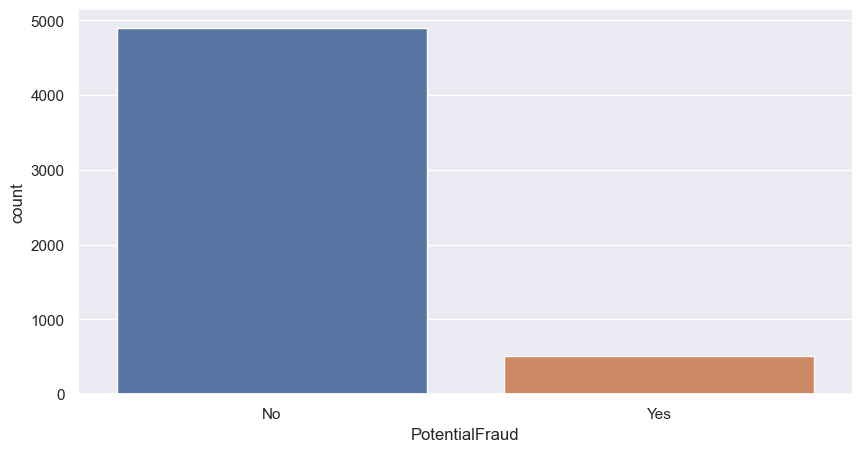

In [5]:
sns.countplot(x='PotentialFraud', data=df_lab)

## **Inpatient data**

**Convert datatypes**

In [6]:
df_in['ClaimStartDt'] = pd.to_datetime(df_in['ClaimStartDt'], infer_datetime_format=True)
df_in['ClaimEndDt'] = pd.to_datetime(df_in['ClaimEndDt'], infer_datetime_format=True)
df_in['claim_duration'] = (df_in['ClaimEndDt'] - df_in['ClaimStartDt']).dt.days

df_in['AdmissionDt']  = pd.to_datetime(df_in['AdmissionDt'], infer_datetime_format=True)
df_in['DischargeDt']  = pd.to_datetime(df_in['DischargeDt'], infer_datetime_format=True)
df_in['hospital_duration'] = (df_in.DischargeDt - df_in.AdmissionDt).dt.days

In [7]:
df_in['AttendingPhysician'] = df_in['AttendingPhysician'].fillna("None")
df_in['OperatingPhysician'] = df_in['OperatingPhysician'].fillna("None")
df_in['OtherPhysician'] = df_in['OtherPhysician'].fillna("None")

In [8]:
# df_in['AttendingPhysician'] = df_in['AttendingPhysician'].astype(pd.StringDtype())

# not-working
for col in df_in.columns: 
    if df_in[col].dtype == 'object':
        df_in[col] = df_in[col].astype('str')

In [9]:
df_in_corr = df_in.loc[:, ['InscClaimAmtReimbursed',
                              'ClmProcedureCode_1','ClmProcedureCode_2','ClmProcedureCode_3',
                              'ClmProcedureCode_4','ClmProcedureCode_5']
                             ].corr()
df_in_corr = round(df_in_corr.corr(), 2)

In [10]:
# sns.heatmap(df_in_corr, annot=True)

**Merge labelled data with inpatient data**

In [11]:
df_in = df_in.merge(df_lab, how='left', left_on='Provider', right_on='Provider')

In [12]:
df_in.PotentialFraud.value_counts()

Yes    23402
No     17072
Name: PotentialFraud, dtype: int64

<AxesSubplot:xlabel='PotentialFraud', ylabel='count'>

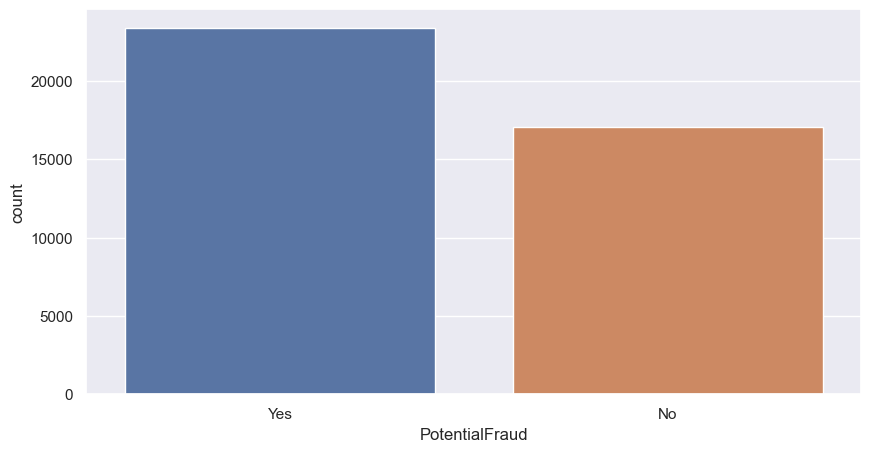

In [13]:
sns.countplot(x='PotentialFraud', data=df_in)

<AxesSubplot:>

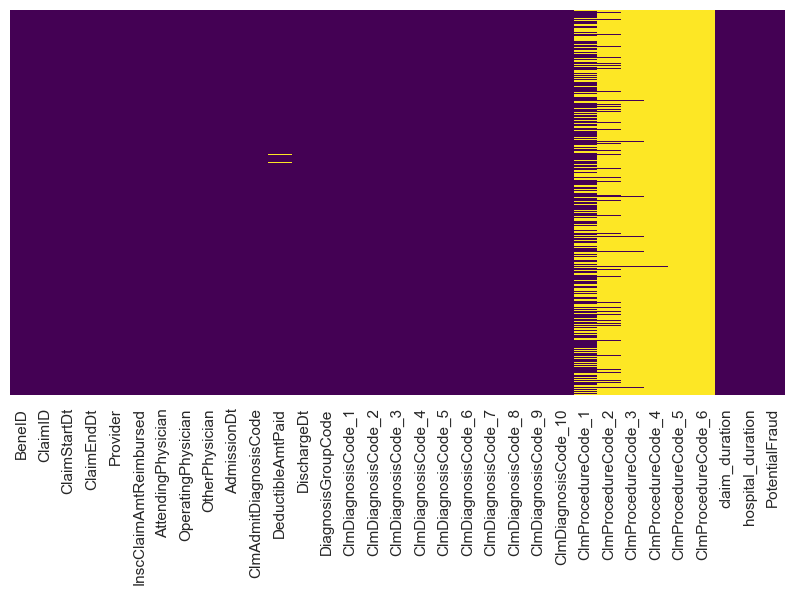

In [14]:
sns.heatmap(df_in.isnull(),yticklabels=False,cbar=False,cmap='viridis')

**Create provider bins**

In [15]:
tmp = df_in.groupby(['Provider']).size()
tmp.name = 'Provcnt'

In [16]:
df_in_new = pd.merge(df_in, tmp, left_on = 'Provider', right_index=True)

In [17]:
bins = pd.cut(df_in_new.Provcnt, bins=4, labels=['low', 'med', 'high', 'top'])

In [18]:
bins.value_counts()

low     31732
med      6961
high     1265
top       516
Name: Provcnt, dtype: int64

## **Outpatient data**

In [19]:
df_out['ClaimStartDt'] = pd.to_datetime(df_out['ClaimStartDt'], infer_datetime_format=True)
df_out['ClaimEndDt'] = pd.to_datetime(df_out['ClaimEndDt'], infer_datetime_format=True)
df_out['claim_duration'] = (df_out['ClaimEndDt'] - df_out['ClaimStartDt']).dt.days
df_out['hospital_duration'] = 0

**Merge labelled data with outpatient data**

In [20]:
df_out = df_out.merge(df_lab, how='left', left_on='Provider', right_on='Provider')

In [21]:
df_out.PotentialFraud.value_counts()

No     328343
Yes    189394
Name: PotentialFraud, dtype: int64

<AxesSubplot:xlabel='PotentialFraud', ylabel='count'>

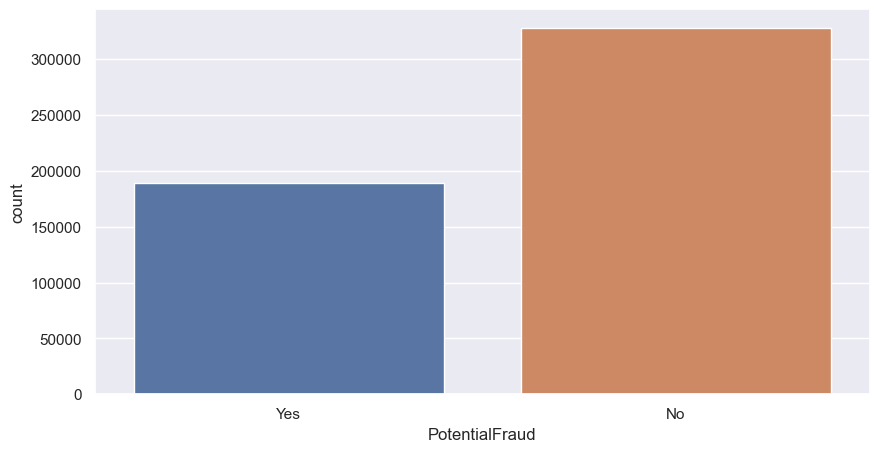

In [22]:
sns.countplot(x='PotentialFraud', data=df_out)

In [23]:
df_out_corr = df_out.loc[:, ['InscClaimAmtReimbursed', 'DeductibleAmtPaid',
                              'ClmProcedureCode_1','ClmProcedureCode_2','ClmProcedureCode_3',
                              'ClmProcedureCode_4']
                             ].corr()
# df_out_corr = round(df_out_corr, 2)

In [24]:
# sns.heatmap(df_out_corr, annot=True)

In [25]:
df_out['AttendingPhysician'] = df_out['AttendingPhysician'].fillna("None")
df_out['OperatingPhysician'] = df_out['OperatingPhysician'].fillna("None")
df_out['OtherPhysician'] = df_out['OtherPhysician'].fillna("None")

<AxesSubplot:>

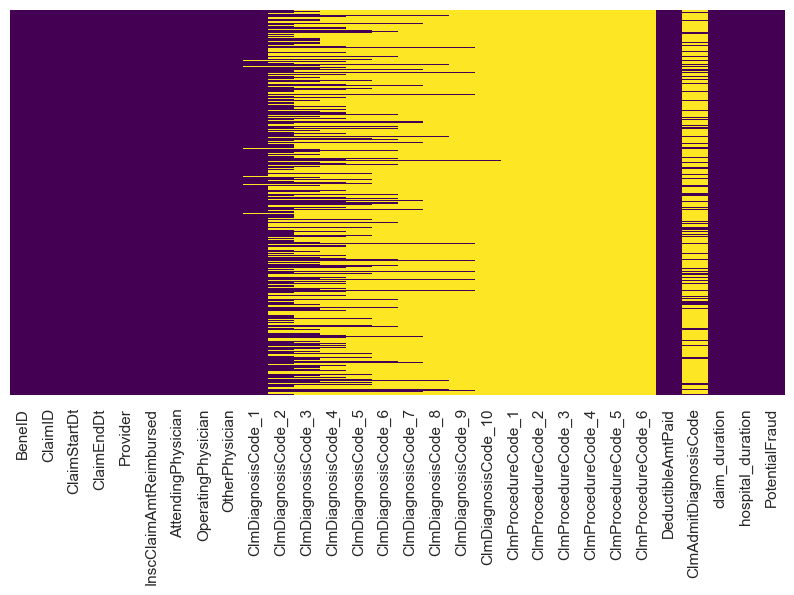

In [26]:
sns.heatmap(df_out.isnull(),yticklabels=False,cbar=False,cmap='viridis')

## **Beneficiary data**

<AxesSubplot:>

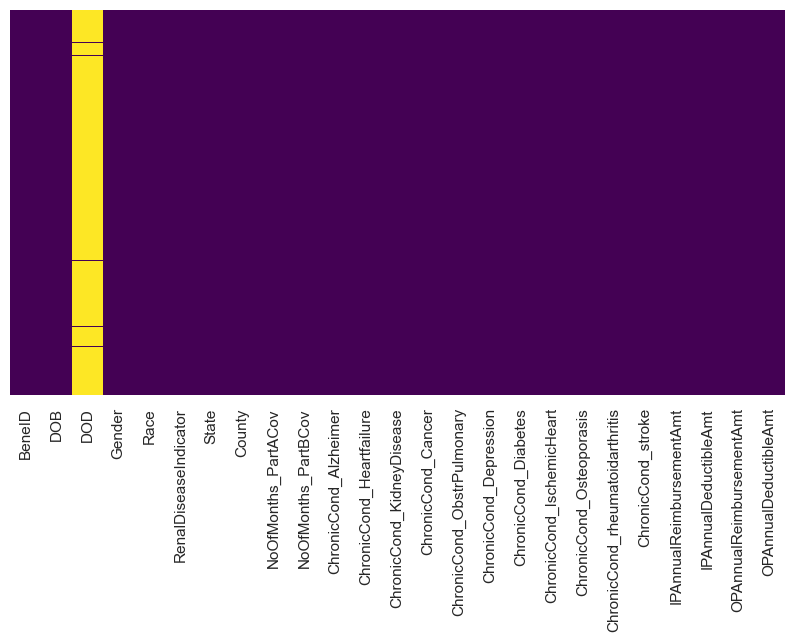

In [27]:
sns.heatmap(df_bene.isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [28]:
df_bene['DOB'] = pd.to_datetime(df_bene['DOB'], format = '%Y-%m-%d')
df_bene['DOD'] = pd.to_datetime(df_bene['DOD'], format = '%Y-%m-%d')

***Age***

The max DOD date is 2009-01-12. This is used to fillin NaN values to cacluate age of beneficiary.

In [29]:
df_bene['DOD'].fillna("2009-12-01", inplace=True)
df_bene['Age'] = df_bene['DOD'].dt.year - df_bene['DOB'].dt.year

In [30]:
# sns.heatmap(df_bene_corr, annot=True)

In [31]:
bene_age_tier = [
    (df_bene['Age'] <= 30),
    (df_bene['Age'] > 30) & (df_bene['Age'] <= 45),
    (df_bene['Age'] > 45) & (df_bene['Age'] <= 64),
    (df_bene['Age'] >= 65)
    ]

In [32]:
bene_age = df_bene['Age']
bene_age = np.select(bene_age_tier, ['Young', 'Early middle' ,'Late middle', 'Senior'])

<AxesSubplot:ylabel='count'>

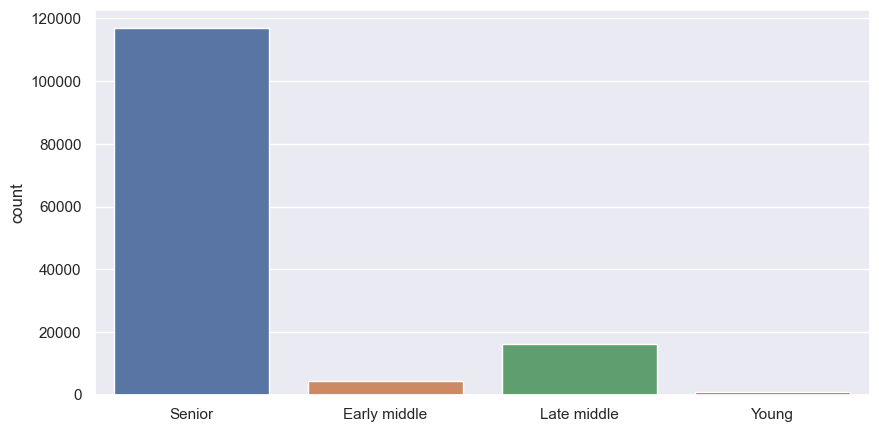

In [33]:
sns.countplot(x=bene_age)
#sns.countplot(x='Age', data=df_bene)

**Bene claimed as inpatient or outpatient**

In [34]:
df_bene['has_claimed_ip'] = df_bene['BeneID'].isin(df_in['BeneID'])
df_bene['has_claimed_op'] = df_bene['BeneID'].isin(df_out['BeneID'])

<AxesSubplot:xlabel='has_claimed_ip', ylabel='count'>

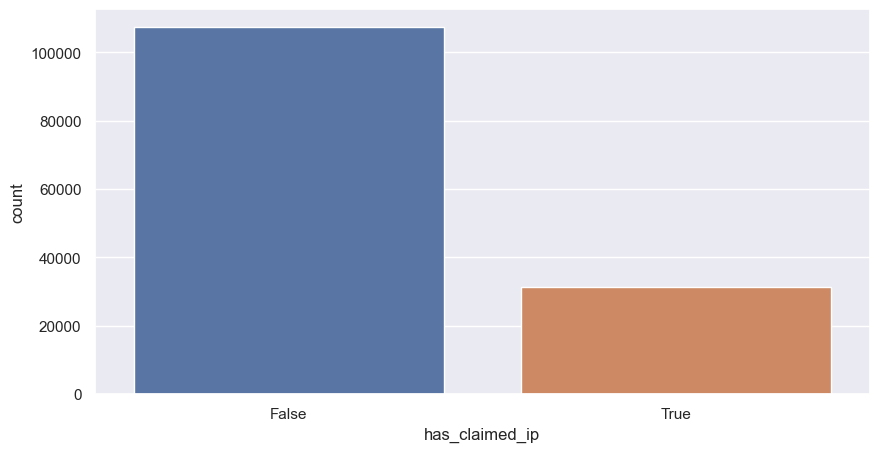

In [35]:
sns.countplot(x='has_claimed_ip', data=df_bene)

<AxesSubplot:xlabel='has_claimed_op', ylabel='count'>

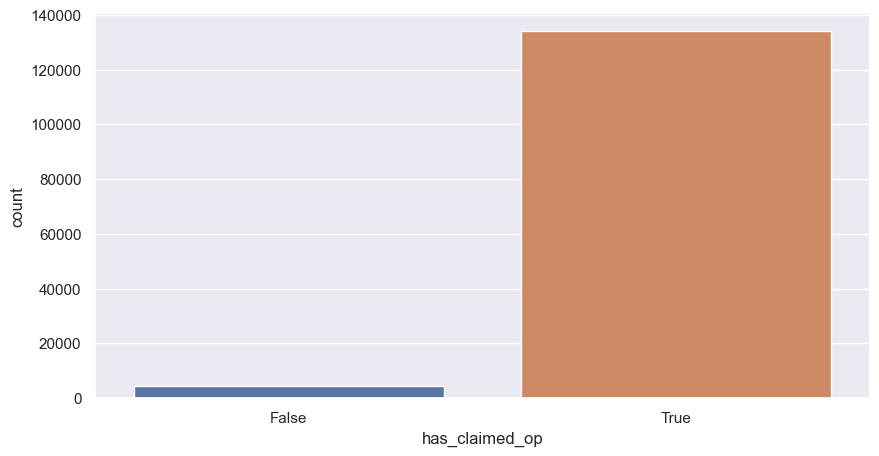

In [36]:
sns.countplot(x='has_claimed_op', data=df_bene)

**Merge beneficiaries with inpatient & outpatient data**

In [37]:
df_in = df_in.merge(df_bene, how='left', left_on='BeneID', right_on='BeneID')
df_out = df_out.merge(df_bene, how='left', left_on='BeneID', right_on='BeneID')

**One-Hot-Encoder**

In [38]:
# encoder = OneHotEncoder(handle_unknown='ignore')

In [39]:
# enc_df = pd.DataFrame(encoder.fit_transform(df_in[['Provider']]).toarray())

In [40]:
tmp = df_in.groupby(['Provider']).size()
tmp.name = 'Provcnt'

In [41]:
# df_all_new = pd.merge(df_all, tmp, left_on = 'Provider', right_index=True)

In [42]:
# bins = pd.cut(df_in.Provcnt, bins=2, labels=['low', 'high'])

<AxesSubplot:xlabel='Gender', ylabel='count'>

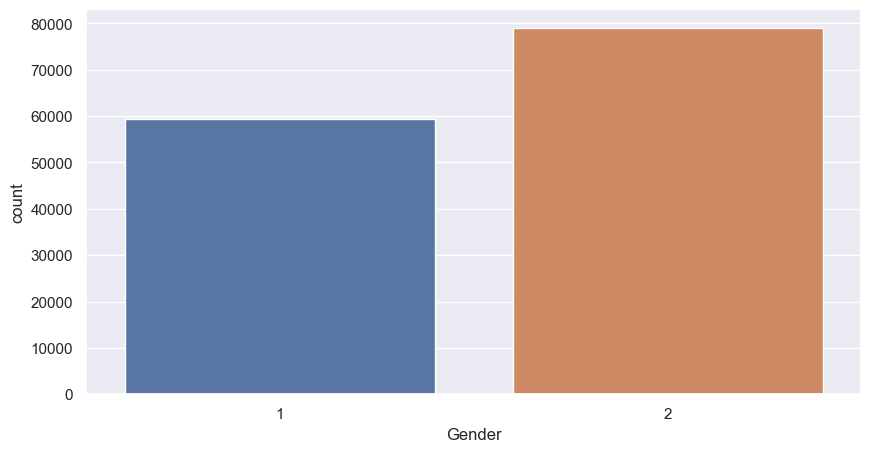

In [43]:
sns.countplot(x='Gender', data=df_bene)

# **Diseases**

**Alzheimers - inpatient**

In [44]:
df_in_bene_Alz = df_in[df_in['ChronicCond_Alzheimer'] == 1]

In [45]:
df_in_bene_Alz.PotentialFraud.value_counts()

Yes    11756
No      8645
Name: PotentialFraud, dtype: int64

<AxesSubplot:xlabel='PotentialFraud', ylabel='count'>

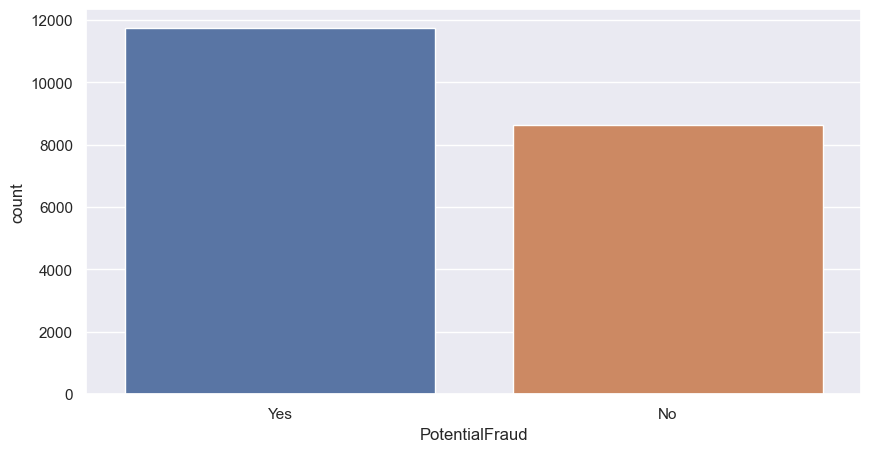

In [46]:
sns.countplot(x='PotentialFraud', data=df_in_bene_Alz)

**Alzheimers - outpatient**

In [47]:
df_out_bene_Alz = df_out[df_out['ChronicCond_Alzheimer'] == 1]

In [48]:
df_out_bene_Alz.PotentialFraud.value_counts()

No     129335
Yes     74591
Name: PotentialFraud, dtype: int64

In [49]:
# sns.countplot(x='PotentialFraud', data=df_out_bene_Alz)

# Exploratory Data Analysis

**Target Labels**

The target variable in the labelled dataset is "PotentialFraud" which indicates whether a provider is fradulent or not. Out of 5410 providers in total, 9.35% are fradulent.

<AxesSubplot:ylabel='PotentialFraud'>

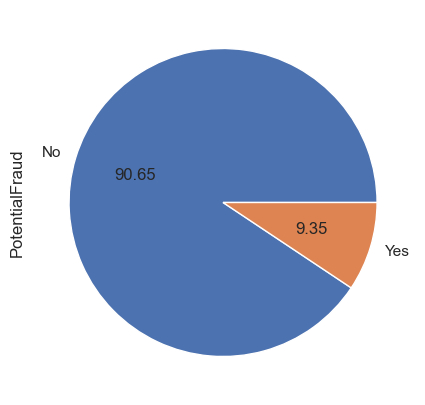

In [50]:
target = df_lab["PotentialFraud"]
target.value_counts().plot.pie(autopct='%.2f',figsize=(6, 5))

**Combine data frames**

In [51]:
df_all = pd.concat([df_in, df_out], ignore_index=True, sort=False)

**Convert datatype to Numeric**

In [52]:
# df_all_corr = df_all.loc[:, ['AttendingPhysician', 'OtherPhysician', 'OperatingPhysician'] ].corr()
# df_all_corr = round(df_all_corr.corr(), 2)

In [53]:
#sns.heatmap(df_all_corr, annot=True)

In [54]:
# df_all.loc[:, ['AttendingPhysician', 'OtherPhysician', 'OperatingPhysician']]

**Physician Fraud Analysis**

In [55]:
df_all_fraud = df_all[df_all.PotentialFraud == 'Yes']

In [56]:
df_all_fraud['AttendingPhysician'].replace(to_replace=['None'], value=np.nan, inplace=True)

/var/folders/tc/c8rjp8hn765724hng7xbcs5h0000gn/T/ipykernel_10455/2521671908.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_all_fraud['AttendingPhysician'].replace(to_replace=['None'], value=np.nan, inplace=True)


In [57]:
df_all_fraud = df_all_fraud.groupby(['AttendingPhysician', 'Provider']).size().reset_index(name='counts')

In [58]:
# df_all_fraud['Provider'].apply('str')
# df_all_fraud['AttendingPhysician'].apply('str')

In [59]:
lower_qrt, middle_qrt, upper_qrt = df_all_fraud.counts.quantile([0.25,0.5,0.75])

In [60]:
conditions = [(df_all_fraud.counts <= lower_qrt),
              (df_all_fraud.counts > lower_qrt) & (df_all_fraud.counts <= middle_qrt),
              (df_all_fraud.counts > middle_qrt) & (df_all_fraud.counts <= upper_qrt),
              (df_all_fraud.counts > upper_qrt)
             ]

values = ['Normal' ,'Less suspicious', 'More suspicious', 'Fraud']

In [61]:
df_all_fraud['Physician_Potential_Fraud'] = np.select(conditions, values)

In [62]:
df_all_fraud

,AttendingPhysician,Provider,counts,Physician_Potential_Fraud
0,PHY311002,PRV57495,1,Normal
1,PHY311008,PRV51868,2,Less suspicious
2,PHY311011,PRV55689,17,Fraud
3,PHY311017,PRV52045,1,Normal
4,PHY311021,PRV56259,1,Normal
...,...,...,...,...
20799,PHY434128,PRV51149,1,Normal
20800,PHY434140,PRV54739,9,Fraud
20801,PHY434142,PRV54566,3,More suspicious
20802,PHY434153,PRV51951,1,Normal


In [63]:
df_all_fraud['Physician_Potential_Fraud'].value_counts()

Normal             8850
Fraud              4644
More suspicious    3710
Less suspicious    3600
Name: Physician_Potential_Fraud, dtype: int64

<AxesSubplot:ylabel='Physician_Potential_Fraud'>

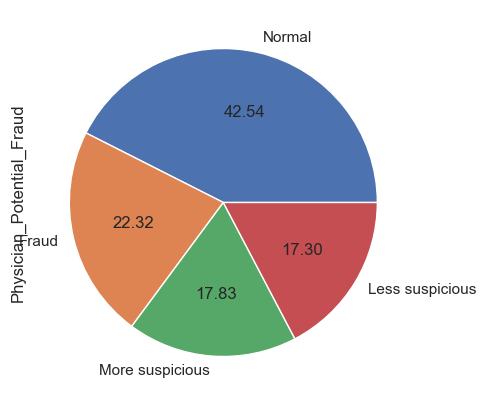

In [64]:
target = df_all_fraud['Physician_Potential_Fraud']
target.value_counts().plot.pie(autopct='%.2f',figsize=(6, 5))

In [65]:
df_all['Physician_Potential_Fraud'] = df_all_fraud['Physician_Potential_Fraud']

In [66]:
df_all['Physician_Potential_Fraud'].fillna("None", inplace=True) # why should this be done ?

In [67]:
df_all['Physician_Potential_Fraud']

0                  Normal
1         Less suspicious
2                   Fraud
3                  Normal
4                  Normal
               ...       
558206               None
558207               None
558208               None
558209               None
558210               None
Name: Physician_Potential_Fraud, Length: 558211, dtype: object

In [68]:
df_all_fraud = df_all[df_all.PotentialFraud == 'Yes']

**Operating Physicial fraud analysis**

In [69]:
df_all_fraud['OperatingPhysician'].replace(to_replace='None', value=np.nan, inplace=True)

/var/folders/tc/c8rjp8hn765724hng7xbcs5h0000gn/T/ipykernel_10455/2517755197.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_all_fraud['OperatingPhysician'].replace(to_replace='None', value=np.nan, inplace=True)


In [70]:
df_all_fraud = df_all_fraud.groupby(['OperatingPhysician', 'Provider']).size().reset_index(name='counts')

In [71]:
conditions = [(df_all_fraud.counts <= lower_qrt),
              (df_all_fraud.counts > lower_qrt) & (df_all_fraud.counts <= middle_qrt),
              (df_all_fraud.counts > middle_qrt) & (df_all_fraud.counts <= upper_qrt),
              (df_all_fraud.counts > upper_qrt)
             ]

values = ['Normal' ,'Less suspicious', 'More suspicious', 'Fraud']

In [72]:
df_all_fraud['Operating_Physician_fraud'] = np.select(conditions, values)

In [73]:
df_all['Operating_Physician_fraud'] = df_all_fraud['Operating_Physician_fraud']

In [74]:
df_all['Operating_Physician_fraud'].fillna('None', inplace=True)

In [75]:
df_all['Operating_Physician_fraud']

0         More suspicious
1         Less suspicious
2                  Normal
3         Less suspicious
4                  Normal
               ...       
558206               None
558207               None
558208               None
558209               None
558210               None
Name: Operating_Physician_fraud, Length: 558211, dtype: object

# **Master dataframe**

In [76]:
df_master = pd.concat([df_in, df_out], ignore_index=True, sort=False)

In [77]:
df_master['RenalDiseaseIndicator'] = df_master['RenalDiseaseIndicator'].map({'Y': 1})
df_master['RenalDiseaseIndicator'] = df_master['RenalDiseaseIndicator'].fillna(0)

In [78]:
df_master['bene_is_in_out_patient'] = np.where((df_master.has_claimed_ip == True) & (df_master.has_claimed_op == True), 1, 0)

In [79]:
df_master_ml = df_master.groupby('Provider').agg(
    Mean_partA=('NoOfMonths_PartACov', np.mean),
    Mean_partB=('NoOfMonths_PartBCov', np.mean),
    Med_race=('Race', np.median),
    Med_gender=('Gender', np.median),
    Med_state=('State', np.median),
    Med_renal=('RenalDiseaseIndicator', np.median),
    Mean_InscClaimAmtReimbursed=('InscClaimAmtReimbursed', np.mean),
    Sum_InscClaimAmtReimbursed=('InscClaimAmtReimbursed', np.sum),
    Count_claims=('ClaimID', 'nunique'),
    Count_patients=('BeneID', 'nunique'),
    Count_attendingPhysician=('AttendingPhysician', 'nunique'),
    Count_operatingPhysican=('OperatingPhysician', 'nunique'),
    Mean_age_bene=('Age',np.mean),
    Mean_hospitalduration=('hospital_duration', np.mean),
    Count_ClmDiagCode_1=('ClmDiagnosisCode_1', 'nunique'),
    Count_ClmDiagCode_2=('ClmDiagnosisCode_2', 'nunique'),
    Count_ClmDiagCode_3=('ClmDiagnosisCode_3', 'nunique'),
    Count_ClmDiagCode_4=('ClmDiagnosisCode_4', 'nunique'),
    Count_ClmDiagCode_5=('ClmDiagnosisCode_5', 'nunique'),
    Count_ClmDiagCode_6=('ClmDiagnosisCode_6', 'nunique'),
    Count_ClmDiagCode_7=('ClmDiagnosisCode_7', 'nunique'),
    Count_ClmDiagCode_8=('ClmDiagnosisCode_8', 'nunique'),
    Count_ClmProcCode_1=('ClmProcedureCode_1', 'nunique'),
    Count_ClmProcCode_2=('ClmProcedureCode_2', 'nunique'),
    Count_ClmProcCode_3=('ClmProcedureCode_3', 'nunique'),
    Count_ClmProcCode_4=('ClmProcedureCode_4', 'nunique'),
    Count_ClmProcCode_5=('ClmProcedureCode_5', 'nunique'),
    Count_ClmProcCode_6=('ClmProcedureCode_6', 'nunique'),
    Sum_bene_is_in_out_pat=('bene_is_in_out_patient', np.sum),
    label=('PotentialFraud', 'unique'),
)

In [80]:
df_master_ml = df_master_ml.explode('label')
df_master_ml.label = df_master_ml.label.replace(to_replace=['Yes', 'No'], value=[1,0])
df_master_ml

,Mean_partA,Mean_partB,Med_race,Med_gender,Med_state,Med_renal,Mean_InscClaimAmtReimbursed,Sum_InscClaimAmtReimbursed,Count_claims,Count_patients,...,Count_ClmDiagCode_7,Count_ClmDiagCode_8,Count_ClmProcCode_1,Count_ClmProcCode_2,Count_ClmProcCode_3,Count_ClmProcCode_4,Count_ClmProcCode_5,Count_ClmProcCode_6,Sum_bene_is_in_out_pat,label
Provider,,,,,,,,,,,,,,,,,,,,,
PRV51001,12.000000,12.000000,1.0,2.0,1.0,0.0,4185.600000,104640,25,24,...,4,3,2,1,0,0,0,0,10,0
PRV51003,11.818182,11.871212,1.0,2.0,1.0,0.0,4588.409091,605670,132,117,...,48,43,32,7,0,0,0,0,66,1
PRV51004,11.865772,11.959732,1.0,2.0,1.0,0.0,350.134228,52170,149,138,...,8,7,0,0,0,0,0,0,31,0
PRV51005,11.907296,11.939914,1.0,2.0,1.0,0.0,241.124464,280910,1165,495,...,61,40,0,0,0,0,0,0,289,1
PRV51007,11.833333,11.833333,1.0,2.0,1.0,0.0,468.194444,33710,72,58,...,9,7,1,0,0,0,0,0,20,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PRV57759,12.000000,12.000000,1.0,1.0,45.0,0.0,380.000000,10640,28,24,...,0,0,0,0,0,0,0,0,6,0
PRV57760,12.000000,11.727273,1.0,1.0,45.0,0.0,216.818182,4770,22,9,...,1,0,0,0,0,0,0,0,8,0
PRV57761,12.000000,12.000000,1.0,2.0,10.0,0.0,225.243902,18470,82,67,...,4,2,0,0,0,0,0,0,28,0


In [81]:
# df_master.loc[df_master.Provider == 'PRV51037']['ClmProcedureCode_1'].nunique()

In [82]:
df_master_ml_corr = round(df_master_ml.corr(), 2)

<AxesSubplot:>

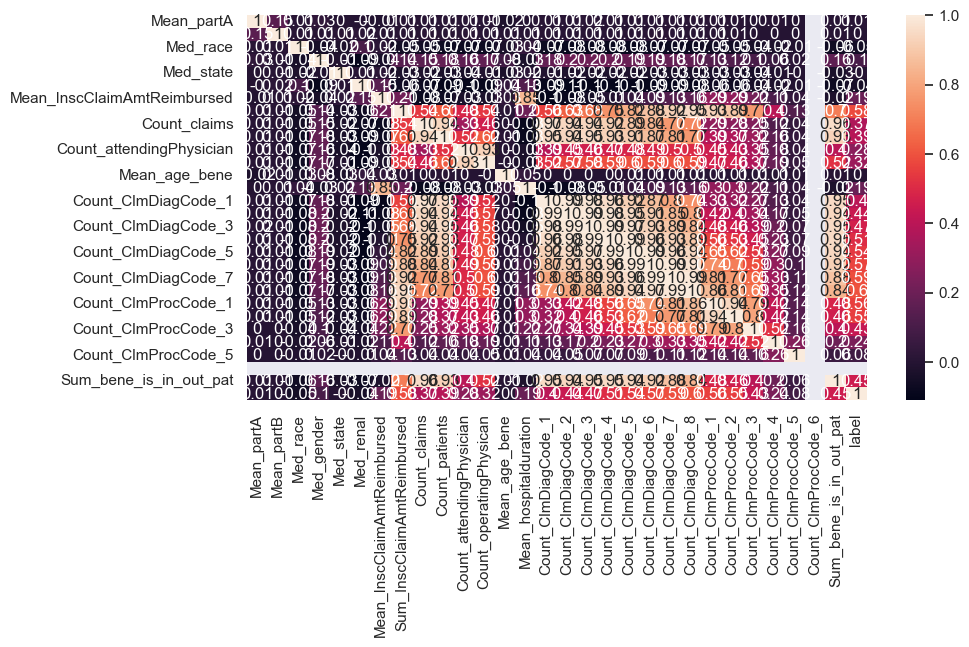

In [83]:
sns.heatmap(df_master_ml_corr, annot=True)

# Modeling

In [84]:
from sklearn.model_selection import train_test_split

X = df_master_ml.drop("label", axis=1)
y = df_master_ml["label"]


In [85]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

In [86]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(max_depth=2, random_state=0)
clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=2, random_state=0)

In [87]:
clf.feature_names_in_

array(['Mean_partA', 'Mean_partB', 'Med_race', 'Med_gender', 'Med_state',
       'Med_renal', 'Mean_InscClaimAmtReimbursed',
       'Sum_InscClaimAmtReimbursed', 'Count_claims', 'Count_patients',
       'Count_attendingPhysician', 'Count_operatingPhysican',
       'Mean_age_bene', 'Mean_hospitalduration', 'Count_ClmDiagCode_1',
       'Count_ClmDiagCode_2', 'Count_ClmDiagCode_3',
       'Count_ClmDiagCode_4', 'Count_ClmDiagCode_5',
       'Count_ClmDiagCode_6', 'Count_ClmDiagCode_7',
       'Count_ClmDiagCode_8', 'Count_ClmProcCode_1',
       'Count_ClmProcCode_2', 'Count_ClmProcCode_3',
       'Count_ClmProcCode_4', 'Count_ClmProcCode_5',
       'Count_ClmProcCode_6', 'Sum_bene_is_in_out_pat'], dtype=object)

In [88]:
y_proba = clf.predict_proba(X_test)

In [113]:
y_pred = clf.predict(X_test)

In [89]:
y_proba[:, 1]

array([0.02274971, 0.01969583, 0.01969583, ..., 0.01969583, 0.02385311,
       0.02069705])

In [90]:
df_evaluation = pd.DataFrame({'y_actual': y_test, 'y_proba': y_proba[:, 1]})

In [91]:
df_evaluation

,y_actual,y_proba
Provider,,
PRV51366,0,0.022750
PRV53158,0,0.019696
PRV56295,0,0.019696
PRV57115,0,0.022072
PRV52342,0,0.511975
...,...,...
PRV54438,0,0.098126
PRV51515,0,0.039471
PRV51222,0,0.019696


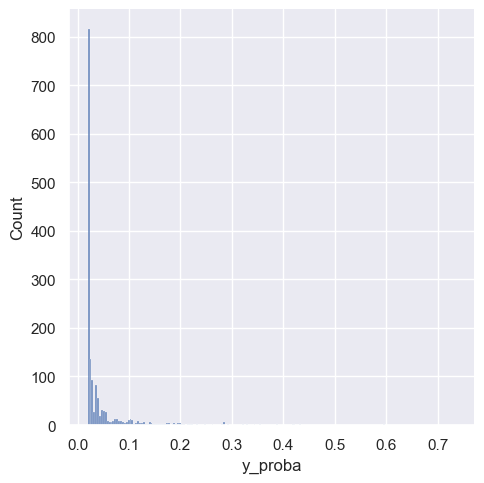

In [92]:
sns.displot(df_evaluation.loc[df_evaluation["y_actual"] == 0, "y_proba"], kde=False)

<AxesSubplot:xlabel='y_proba', ylabel='Density'>

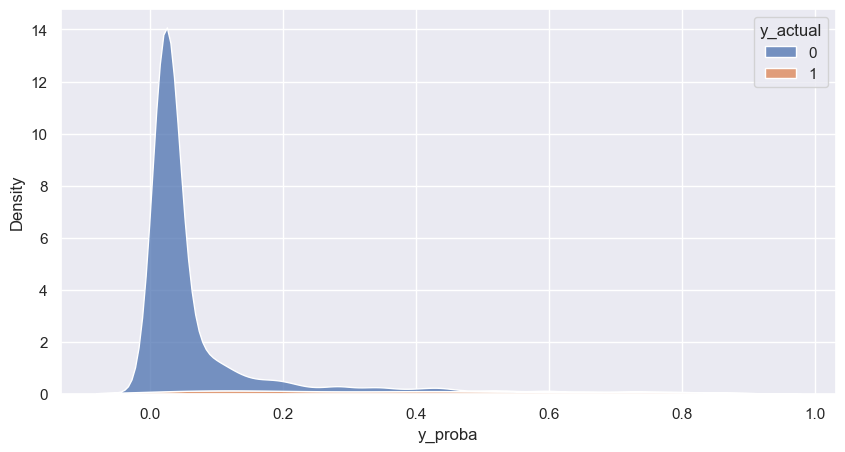

In [93]:
sns.kdeplot(data=df_evaluation, x="y_proba", hue="y_actual", multiple="stack")
# sns.countplot(x='PotentialFraud', data=df_in_bene_Alz)

(0.0, 1.0)

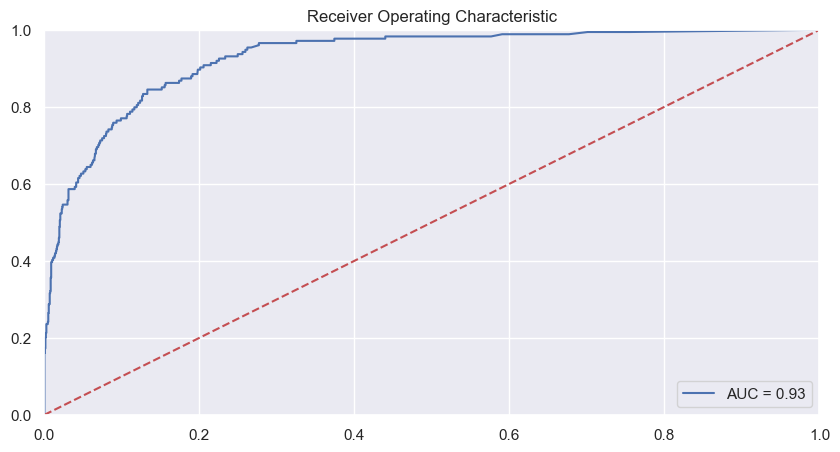

In [97]:
import sklearn.metrics as metrics
# calculate the fpr and tpr for all thresholds of the classification
probs = clf.predict_proba(X_test)
preds = y_proba[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
# plt.y

In [114]:
y_pred

array([0, 0, 0, ..., 0, 0, 0])

In [120]:
from sklearn.metrics import confusion_matrix
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

In [123]:
display(tn, fp, fn, tp)

1599

13

114

60

In [126]:
pred_scores = y_proba[:, 1]

In [127]:
actual_scores = y_test

In [131]:
temp = pd.DataFrame({'pred_scores': pred_scores, 'y_pred': y_pred, 'actual_scores': actual_scores})

In [136]:
temp.loc[temp['y_pred']==1,:]

,pred_scores,y_pred,actual_scores
Provider,,,
PRV52342,0.511975,1,0
PRV51378,0.745274,1,1
PRV55689,0.751136,1,1
PRV56689,0.780486,1,1
PRV51480,0.771317,1,1
...,...,...,...
PRV54765,0.780776,1,1
PRV56350,0.518448,1,1
PRV51159,0.635456,1,1


Write a function to compute ROC and compare with library
Computing Recall and Precisioin for threshold of 0.5
Create PR curve
Imbalanced data